# DBSCAN (Density-Based Spatial Clustering of Aplication with Noise)

+ Clustering basado en desidad.
+ Su principio se basa en que un cluster tiene alta densidad, mientras que la región que los separa nola tiene.
+ La idea pricipal es que cada punto del cluster de acuerdo a un radio dado debe tener un mínimo de vecinos o puntos cercanos para encontrar densidad.
+ Requiero dos parámetros -> eps(epsilon) MinPts(Minimo de puntos aceptables en el cluster).

![DBSCAN_parametros](./img/DBSCAN_parametros.png)

+ No trabaja unicamente con formas esfeicas como Kmeans para crear los clusters.

![DBSCAN_formas](./img/DBSCAN_formas.png)


Se puede dar tres escenarios cuando se crean los clusters
+ **Core Point**: Eres un punto que en el vecindario que se cumple con la cantidad o mas con los puntos minimos establecidos.
+ **Border Point**: Punto que no tienen la cantidad minima de puntos estanblecida pero que tiene vecindad con algunos de ellos.
+ **Noise**: Punto que representa ruido.

![DBSCAN_escenarios](./img/DBSCAN_escenarios.png)

+ Cuando un Core Point conecta con otro Core Point se suma del mismo cluster y si esta conecta con otro de estos lo va agregando al cluster, luego empieza busca conectar con los Border Point.
+ Tamaños muy pequeños del epsilon hace que el algorintmo tarde mucho o que cree muchos cluster inecesarios o si es muy grnades que nunca converja

## Ventajas
+ No requeire especificar el número de clusters.
+ Es capaz de detectar outliers o ruido.
+ Puede encontrar clusters en formas y tamaños arbitrarios.

## Desventajas
+ Los hiper-parámetros son muy determinantes, algunas combinaciones no funcionan igual para todos los grupos con distintas densidades.
+ Los puntos fronterizos a los que puede acceder desde más de un cluster pueden formar parte de cualquier cluster.

## ¿Cuando usarlo? 

+ Desconozco la cantidad de clusters.
+ No uso formas esféricas.
+ Densidad similares entre clusters

## Importar librerias

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

## Preparando datos de prueba

In [11]:
X, y, c = make_blobs(500, cluster_std=0.8, centers=4, n_features=2,return_centers=True)

df_blobs = pd.DataFrame(
    {
        'x1': X[:,0],
        'x2': X[:,1]
    }
)

df_centers = pd.DataFrame(
    {
        'x1': c[:,0],
        'x2': c[:,1],
    }
)

In [12]:
X_m ,y_m = make_moons(n_samples=250, noise=0.05, random_state=42)

df_moons = pd.DataFrame(
    {
        'x1': X_m[:,0],
        'x2': X_m[:,1]
    }
    )

## Visualización de datos

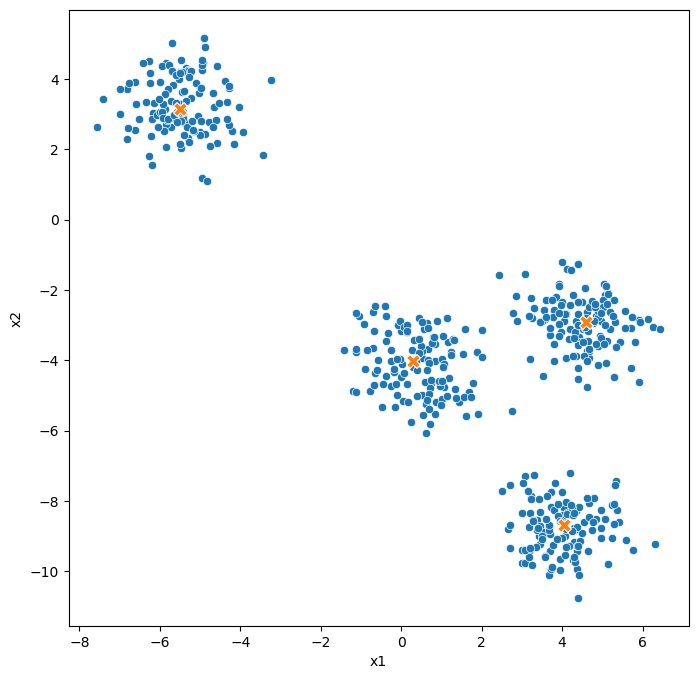

In [13]:
fig = plt.figure(figsize=(8,8))
sns.scatterplot(data=df_blobs, x='x1', y='x2')
sns.scatterplot(data=df_centers, x='x1', y='x2', marker='X', s = 100)
plt.plot()
plt.show()

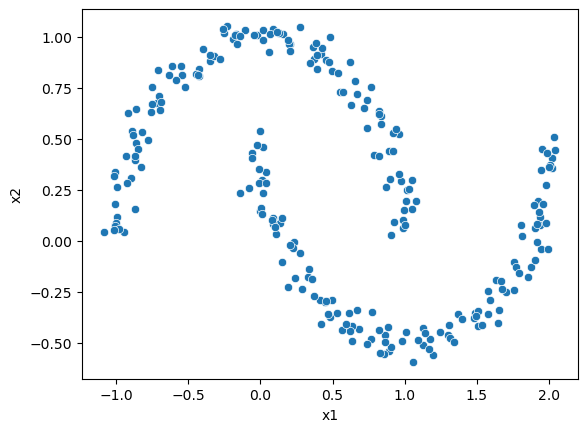

In [14]:
sns.scatterplot(data=df_moons, x='x1', y='x2')
plt.show()

## Implementado DBSCAN

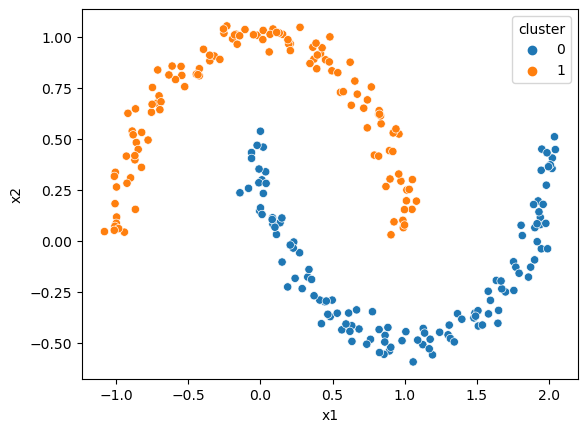

In [15]:
dbscan_cluster = DBSCAN(eps=0.3, min_samples=3)
y_m_predict = dbscan_cluster.fit_predict(X_m)
df_moons['cluster'] = y_m_predict
sns.scatterplot(data=df_moons, x='x1', y='x2', hue='cluster')
plt.show()

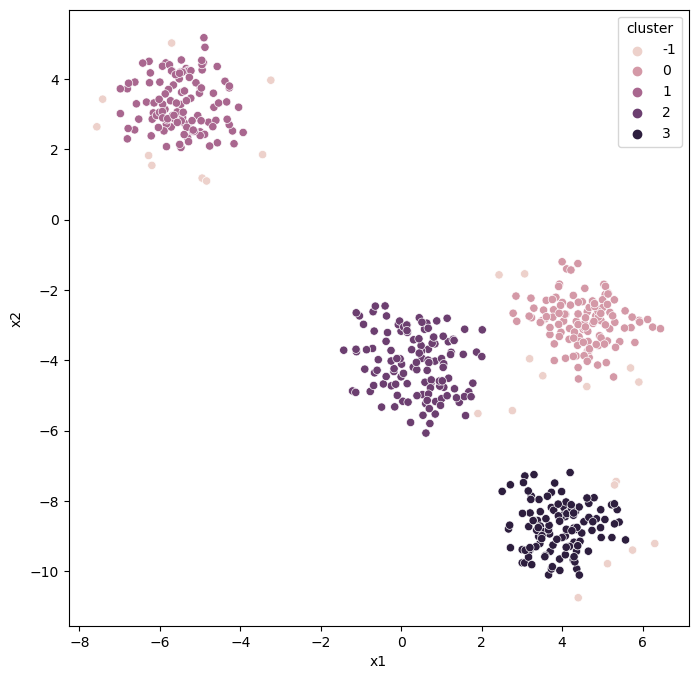

In [22]:
dbscan = DBSCAN(eps=0.5, min_samples=4)
y_predict = dbscan.fit_predict(X)
df_blobs['cluster'] = y_predict

fig = plt.figure(figsize=(8,8))
sns.scatterplot(data=df_blobs, x='x1', y='x2', hue='cluster')
plt.plot()
plt.show()

## Hyperparameters

In [23]:
from sklearn.neighbors import NearestNeighbors

In [24]:
# Encontrar la distancia de los tres vecinos mas cercanos en cada punto
neighbors = NearestNeighbors(n_neighbors=3)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

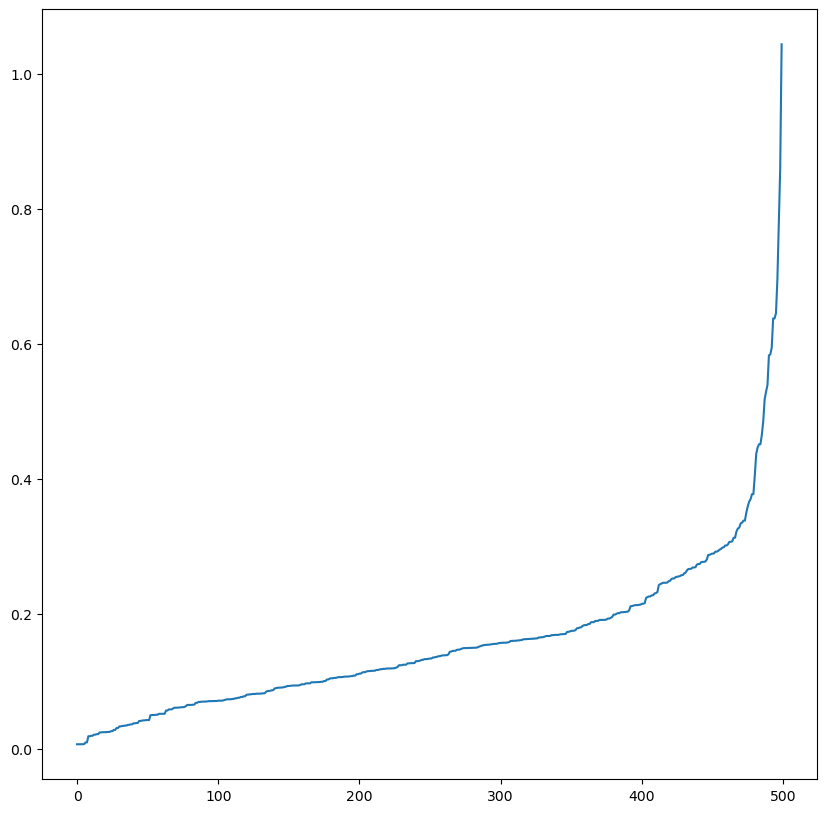

In [25]:
# distancias ordenadas de menor a mayor
distances = np.sort(distances, axis=0)

distances = distances[:, 1]

fig = plt.figure(figsize=(10,10))
plt.plot(distances)

Se usa el metodo de la rodilla para determinar el epsilon, en este caso estaria entre 0.25 y 0.8

In [41]:
eps_values = np.arange(0.25, 0.8, 0.1)
min_samples = np.arange(2, 10)

In [42]:
from itertools import product

In [43]:
dbscan_paramns = list(product(eps_values, min_samples))

In [44]:
sil_scores = []

for p in dbscan_paramns:
    y_pred = DBSCAN(eps=p[0], min_samples=p[1]).fit_predict(X)
    sil_scores.append(silhouette_score(X, y_pred))

In [45]:
df_paramns_tunning = pd.DataFrame.from_records(dbscan_paramns, columns=['eps', 'min_samples'])
df_paramns_tunning['sil_scores'] = sil_scores
df_paramns_tunning.head()

,eps,min_samples,sil_scores
0,0.25,2,-0.075994
1,0.25,3,-0.054631
2,0.25,4,-0.085575
3,0.25,5,-0.165939
4,0.25,6,-0.260636


In [46]:
pivot_data = pd.pivot_table(df_paramns_tunning, values='sil_scores', index='min_samples', columns='eps')
pivot_data

eps,0.25,0.35,0.45,0.55,0.65,0.75
min_samples,,,,,,
2,-0.075994,0.023376,0.286470,0.606508,0.526664,0.620246
3,-0.054631,0.270036,0.582328,0.711288,0.699746,0.690816
4,-0.085575,0.210549,0.576273,0.705183,0.699746,0.690816
5,-0.165939,0.268149,0.506085,0.702152,0.707967,0.690816
6,-0.260636,0.407572,0.610440,0.686884,0.710195,0.690816
7,-0.332609,0.242732,0.485190,0.666876,0.704511,0.707659
8,-0.444450,0.233269,0.538829,0.651813,0.704477,0.707659
9,-0.376850,0.070430,0.513139,0.630562,0.700940,0.716243


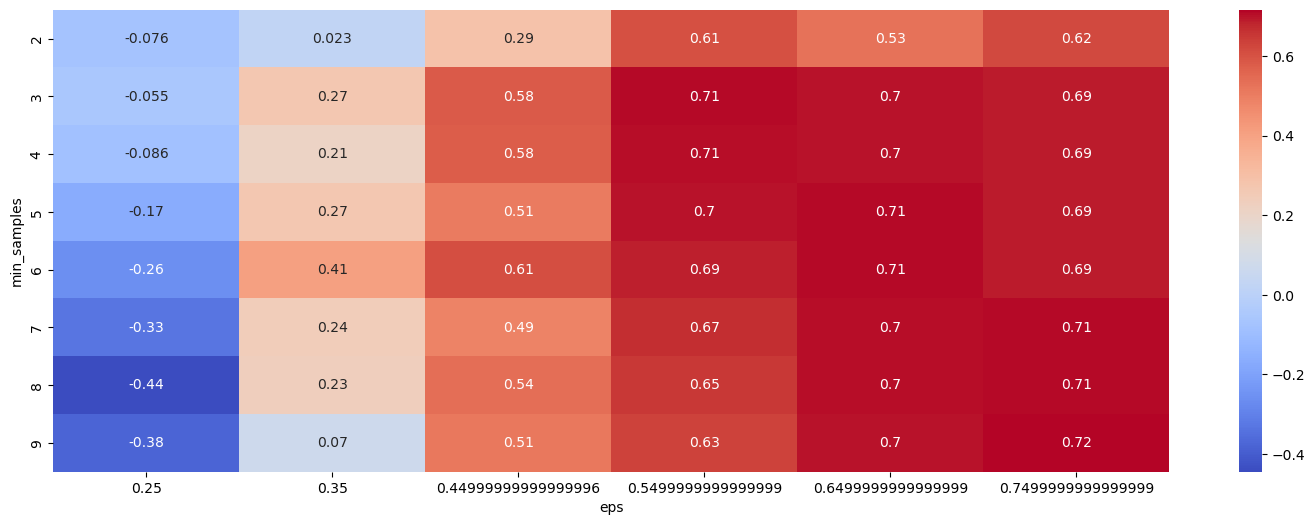

In [47]:
fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(data=pivot_data, annot=True, annot_kws={'size': 10}, cmap='coolwarm', ax=ax)
plt.show()

## Evaluando

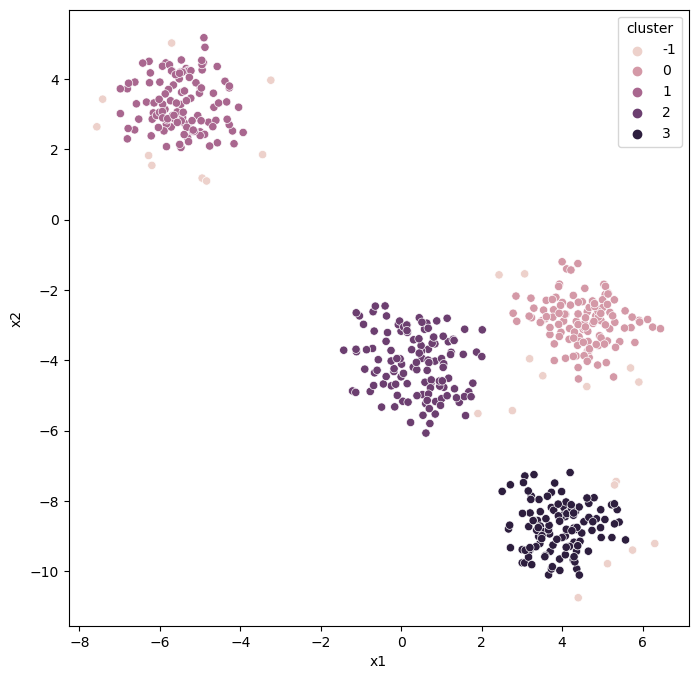

In [48]:
dbscan_cluster = DBSCAN(eps=0.75, min_samples=9)
y_predict = dbscan.fit_predict(X)
df_blobs['cluster'] = y_predict

fig = plt.figure(figsize=(8,8))
sns.scatterplot(data=df_blobs, x='x1', y='x2', hue='cluster')
plt.plot()
plt.show()

For n_clusters = 5 The average silhouette_score is : 0.7162429015883668


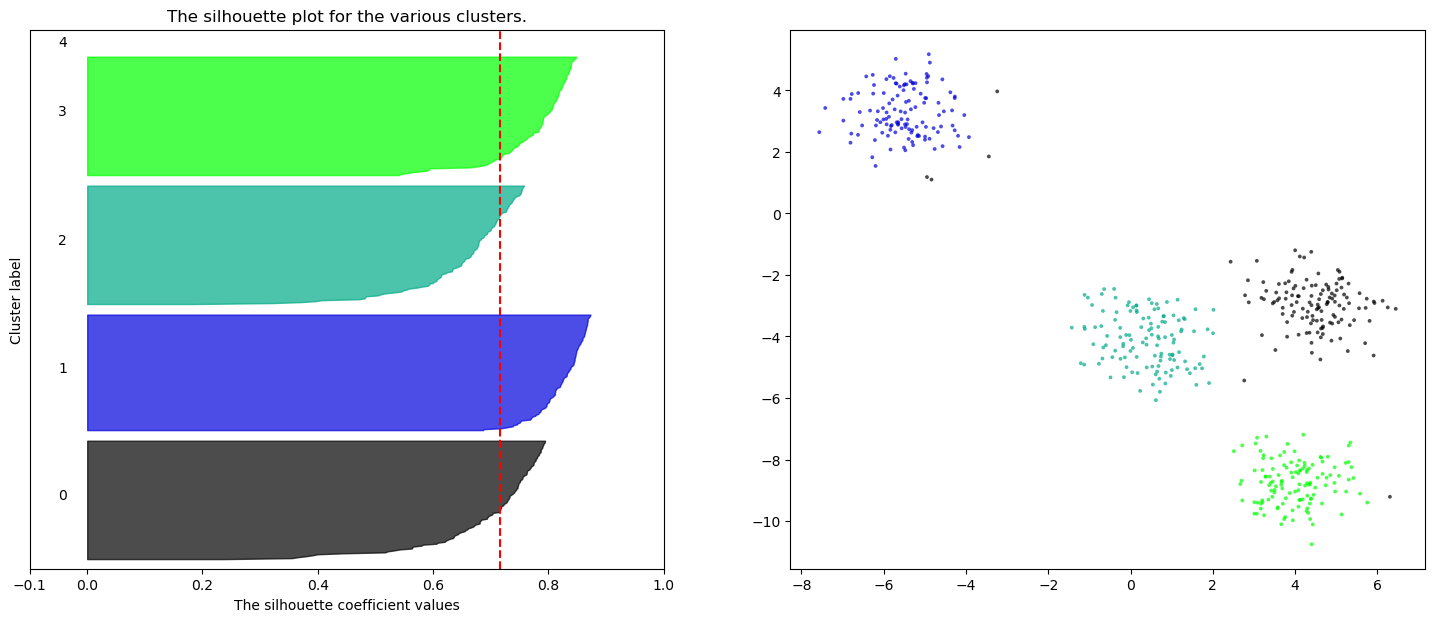

In [49]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np



# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])

clusters = DBSCAN(eps=0.75, min_samples=9)
cluster_labels = clusters.fit_predict(X)

n_clusters = len(np.unique(cluster_labels))
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])


# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(X, cluster_labels)
print(
    "For n_clusters =",
    n_clusters,
    "The average silhouette_score is :",
    silhouette_avg,
)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(
    X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
)


plt.show()